In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import *
import re

# hide warnings
import warnings 
warnings.filterwarnings("ignore")

In [3]:
training_data = pd.read_csv('Data/train.csv', index_col = [0])

In [4]:
training_data.head()

,id,query,product_title,product_description,median_relevance
0,0,zippo hand warmer,"Zippo Black Polish Hand Warmer, with Filling C...",NaN,4
1,1,wall mirrors,Cooper Classics Benedetta Wall Mirrors - 12 di...,The small round shape and shiny nickel finish ...,4
2,2,rachel ray cookware,Rachael Ray Porcelain II Green 10-piece Cookwa...,This versatile 10-piece cookware set from Rach...,4
3,3,flea and tick control for dogs,Hartz UltraGuard Plus Flea and Tick Home Fogge...,details\nThe Hartz UltraGuard Plus Home Fogger...,3
4,4,batman,DC Comics Arkham Asylum Batman Series The Joke...,<ul>\n\t\t<li>\n\t\t\tEnglish \n\t\t\t\t</li>\...,2


In [5]:
test_data = pd.read_csv('Data/test.csv', index_col = [0])

In [6]:
test_data.head()

,id,query,product_title,product_description,median_relevance
0,0,pittsburgh pirates,Fanmats Machine-Made Pittsburgh Pirates Black ...,Show your team pride and add style to your tai...,4
1,1,dish towels,Oasis Cotton Flour Sack Towel (Set of 3),These Flour Sack Towelsoffers the ultimate in ...,3
2,2,portable hard drive,Toshiba Canvio Slim 1 TB External Hard Drive,Toshiba Canvio® Slim II for Mac® Portable Exte...,3
3,3,playstation vita system,Legends Of Chima: Laval's Journey (PlayStation...,Get ready for an epic adventure as Laval races...,2
4,4,galaxy note 3,3M Natural View Screen Protection Film for Sam...,"Helps keep your device screen in pristine, lik...",2


In [11]:
training_data.isna().sum()

id                     0
query                  0
product_title          0
product_description    0
median_relevance       0
dtype: int64

In [12]:
test_data.isna().sum()

id                     0
query                  0
product_title          0
product_description    0
median_relevance       0
dtype: int64

In [13]:
training_data.product_description = training_data.product_description.fillna('')
test_data.product_description = test_data.product_description.fillna('')

In [14]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7618 entries, 0 to 7617
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   7618 non-null   int64 
 1   query                7618 non-null   object
 2   product_title        7618 non-null   object
 3   product_description  7618 non-null   object
 4   median_relevance     7618 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 357.1+ KB


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540 entries, 0 to 2539
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   2540 non-null   int64 
 1   query                2540 non-null   object
 2   product_title        2540 non-null   object
 3   product_description  2540 non-null   object
 4   median_relevance     2540 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 119.1+ KB


Preprocessing

In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words -= {'http','www','img','border','color','style','padding','table','font','inch','width','height'}

In [17]:
# stop word removal
def preprocess(text):
  doc = nlp(text)
  return [token.lemma_ for token in doc if(not token.is_stop and token.lemma_.isalpha())]

In [18]:
from sklearn.feature_extraction import text
# stop word removal
stemmer = PorterStemmer()
sw=[]
ML_STOP_WORDS = ['http','www','img','border','color','style','padding','table','font','inch','width','height']
ML_STOP_WORDS += list(text.ENGLISH_STOP_WORDS)
for stw in ML_STOP_WORDS:
    sw.append(str(stw))
ML_STOP_WORDS += sw
for i in range(len(ML_STOP_WORDS)):
    ML_STOP_WORDS[i]=stemmer.stem(ML_STOP_WORDS[i])

In [19]:
# declarations
def ML_TEXT_CLEAN(f2,f3):
    if len(f2)<3:
        f2="feature2null"
    if len(f3)<3:
        f3="feature3null"
    tx = BeautifulSoup(f3)
    tx1 = [x.extract() for x in tx.findAll('script')]
    tx = tx.get_text(" ").strip()
    s = (" ").join([str(z) for z in f2.split(" ")]) + " " + tx
    s = re.sub("[^a-zA-Z0-9]"," ", s)
    s = re.sub("[0-9]{1,3}px"," ", s)
    s = re.sub(" [0-9]{1,6} |000"," ", s)
    s = (" ").join([stemmer.stem(z) for z in s.split(" ") if len(z)>2])
    s = s.lower()
    return s

In [20]:
# Cleaning training data
s_data = []
for i in range(len(training_data.id)):
    s = ML_TEXT_CLEAN(training_data.product_title[i], training_data.product_description[i])
    s_data.append((training_data["query"][i], s, str(training_data["median_relevance"][i])))

In [21]:
# Cleaning test data
t_data = []
for i in range(len(test_data.id)):
    s = ML_TEXT_CLEAN(test_data.product_title[i], test_data.product_description[i])
    t_data.append((test_data["query"][i], s, test_data.id[i]))

In [22]:
training_df = pd.DataFrame(s_data)
test_df = pd.DataFrame(t_data)



---



Naive Bayes

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
clf = MultinomialNB(alpha=0.01)
v = TfidfVectorizer(use_idf=True,min_df=0,ngram_range=(1,6),lowercase=True,sublinear_tf=True, stop_words = ML_STOP_WORDS)
clf.fit(v.fit_transform(training_df[1]), training_df[2])

MultinomialNB(alpha=0.01)

In [25]:
t_labels_nb = clf.predict(v.transform(test_df[1]))

In [26]:
t_labels_nb
t_labels_nb_df = pd.DataFrame (t_labels_nb, columns = ['median_relevance'])

In [27]:
t_labels_nb_df = pd.to_numeric(t_labels_nb_df['median_relevance'])

In [28]:
print(classification_report(test_data['median_relevance'], t_labels_nb_df))

              precision    recall  f1-score   support

           1       0.57      0.24      0.34       186
           2       0.33      0.24      0.28       337
           3       0.31      0.20      0.24       451
           4       0.70      0.86      0.77      1566

    accuracy                           0.62      2540
   macro avg       0.48      0.39      0.41      2540
weighted avg       0.57      0.62      0.58      2540



In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

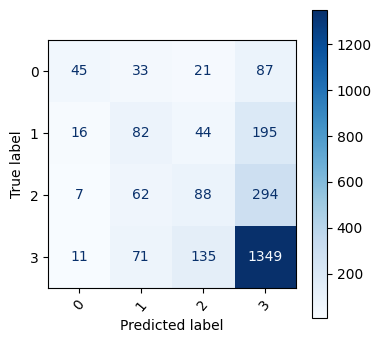

In [30]:
# plot the confusion matrix
base_cm = confusion_matrix(test_data['median_relevance'], t_labels_nb_df)
base_disp = ConfusionMatrixDisplay(confusion_matrix=base_cm)

base_disp.plot(cmap=plt.cm.Blues)
base_disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()



---



Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

In [34]:
# Grid search parameters
param_grid = {
    'vectorizer__binary': (True, False),
    'classifier__alpha': (0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5),
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

# Classifier and the vectorizer
clf = MultinomialNB()
v = TfidfVectorizer(use_idf=True, min_df=0, lowercase=True, sublinear_tf=True, stop_words=ML_STOP_WORDS)

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', v),
    ('classifier', clf)
])

# Perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, refit=True)
grid_search.fit(training_df[1], training_df[2])

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'classifier__alpha': 0.1, 'vectorizer__binary': True, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.6187958735952491
